# Reinforcement Learning in a Smart Factory

## **Import necessary libraries:**

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from mdptoolbox import mdp
from itertools import product
from collections import Counter

## **Load training set...:**

In [170]:
training_set = []
with open("./data/warehousetraining2x2.txt") as f:
    for line in f:
        content = line.splitlines()[0].split("\t")            # Get rid of any special characters.
        training_set.append(content[0] + " " + content[1])    # Fuse action and item back together.
training_set[0:10]                                            # Display first ten items.

['store red',
 'store red',
 'store red',
 'store white',
 'restore red',
 'restore red',
 'restore red',
 'restore white',
 'store blue',
 'store blue']

## **...and test set:**

In [171]:
test_set = []
with open("./data/warehouseorder2x2.txt") as f:
    for line in f:
        content = line.splitlines()[0].split("\t")
        test_set.append(content[0] + " " + content[1])
test_set[0:10]

['store red',
 'store white',
 'restore white',
 'store red',
 'store blue',
 'store red',
 'restore red',
 'restore red',
 'restore red',
 'store red']

## **Plot distribution of training set:**

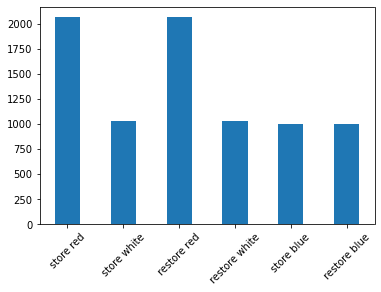

In [172]:
counted = Counter(training_set)                          # Count the occurences of each action.
plt.bar(counted.keys(), counted.values(), width=0.45)    # Bar plot.
plt.xticks(rotation=45)                                  # Rotate the labels on the x-axis.
plt.show()                                               # Show the bar plot.

## **Define dictionaries for color and action for a consistent assignment:**

In [173]:
item_dict = {"empty": 0, "white": 1, "blue": 2, "red": 3}
action_dict = {"store white": 0, "restore white": 1, "store blue": 2,
             "restore blue": 3, "store red": 4, "restore red": 5}
action_reverse_dict = {0: "store white", 1: "restore white", 2: "store blue",
                      3: "restore blue", 4: "store red", 5: "restore red"}
reward_dict = {0: 10, 1: 5, 2: 5, 3: 2.5, "error": -25}

## **Define parameters:**

In [174]:
# Environmental parameters, you can change these.
warehouse_shape = (2, 2)    # Shape of warehouse.
num_items = 4               # {red, white, blue, empty}
num_actions = 6             # {store white, restore white,...}

num_cells = np.prod(warehouse_shape)
num_states = num_items ** num_cells * num_actions
num_states, num_cells

(1536, 4)

## **Define function to generate all possible states:**

In [175]:
def get_states(num_items, num_cells, num_states, num_actions):
    """The first four indices represent whether a specific item (empty, red, white, blue) is available
       in this field. The fifth index tells which action should be performed (store red,...)"""
    states = []                                          # List of states.
    items = np.arange(num_items)                         # List of items, e.g. [0,1,2,3].
    cross = list(product(items, repeat=num_cells))       # States of the warehouse.
    for state in cross:
        for i in range(num_actions):
            states.append(state + (i,))                  # Append actions as additional state.
    return np.array(states)
    

states = get_states(num_items, num_cells, num_states, num_actions)
print(len(states))
states[0:10]

1536


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 2],
       [0, 0, 0, 0, 3],
       [0, 0, 0, 0, 4],
       [0, 0, 0, 0, 5],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 1, 2],
       [0, 0, 0, 1, 3]])

## **Define function to calculate the transition model:**

In [176]:
def get_transition_matrix(num_cells, num_states):
    probs = np.zeros((num_cells, num_states, num_states))        # The resulting probability matrix.
    
    # Put probabilities for each action in a list, sorted the same way as action_(reverse_)dict.
    item_probs = [x for x in range(6)]
    item_probs = [action_reverse_dict[x] for x in item_probs]
    item_probs = [counted[x] for x in item_probs]
    s = sum(item_probs)
    item_probs = [x/s for x in item_probs]
    for pos in range(num_cells):
        for i, state in enumerate(states):
            order = action_reverse_dict[state[-1]].split(" ")    # Split into action and color.
            next_state = state.copy()                            # Create a copy just to make sure.
            next_state[-1] = 0                                   # Facilitates the assignment of probabilities.
            if order[0].startswith("restore"):
                if state[pos] == item_dict[order[1]]:
                    # We can restore the item.
                    next_state[pos] = item_dict["empty"]
            else:
                if state[pos] == item_dict["empty"]:
                    # We can store the item.
                    next_state[pos] = item_dict[order[1]]
            col_idx = np.where(np.all(states == next_state, axis=1))[0][0]
            probs[pos][i][col_idx:col_idx+6] = item_probs        # Assign probabilities.
    return probs

probs = get_transition_matrix(num_cells, num_states)

In [177]:
def get_rewards(num_states, num_cells):
    rewards = np.zeros((num_states, num_cells))        # The resulting reward matrix.
    for i, state in enumerate(states):
        # Iterate over all states.
        order = action_reverse_dict[state[-1]].split(" ")
        if order[0].startswith("restore"):
            for pos in range(num_cells):
                # Iterate over all positions
                if state[pos] == item_dict[order[1]]:
                    # We can restore the item.
                    rewards[i][pos] = reward_dict[pos]
                else:
                    # Restoring the item failed.
                    rewards[i][pos] = reward_dict["error"]
        else:
            for pos in range(num_cells):
                if state[pos] == item_dict["empty"]:
                    # We can store the item.
                    rewards[i][pos] = reward_dict[pos]
                else:
                    # Storing the item failed.
                    rewards[i][pos] = reward_dict["error"]
    return rewards

rewards = get_rewards(num_states, num_cells)

## **Train the models:**

In [178]:
# Hyperparameters
discount = 0.999
max_iterations = 10000

# Various MDP Algorithms.
mdp_policy = mdp.PolicyIteration(probs, rewards, discount, max_iter=max_iterations)
mdp_value = mdp.ValueIteration(probs, rewards, discount, max_iter=max_iterations)
mdp_policy_modified = mdp.PolicyIterationModified(probs, rewards, discount, max_iter=max_iterations)
mdp_q = mdp.QLearning(probs, rewards, discount, n_iter=max_iterations)
mdp_relative = mdp.RelativeValueIteration(probs, rewards, discount, max_iter=max_iterations)
mdp_gs = mdp.ValueIterationGS(probs, rewards, discount, max_iter=max_iterations)

# Run the algorithms.
mdp_policy.run()
mdp_value.run()
mdp_policy_modified.run()
mdp_q.run()
mdp_relative.run()
mdp_gs.run()

## **Evaluate the models:**

#### First, let's define the greedy algorithm, which we will compare our trained models with:

In [179]:
def greedy(test_set, num_cells):
    # Get the distances to each warehouse cell.
    indices = np.indices(warehouse_shape)
    distances = (indices[0] + indices[1] + 1) * 2
    distances = distances.flatten()
    
    # Sort the distances and store their indices.
    indices = np.argsort(distances)
    total_distance = 0
    total_reward = 0
    current_state = np.zeros(num_cells)
    for order in test_set:
        # Iterate over test set.
        order_split = order.split(" ")
        done = False
        if order.startswith("store"):
            for idx in indices:
                # Iterate over cells, starting from the closest to the farthest ones.
                if current_state[idx] == item_dict["empty"]:
                    # We can store the item.
                    current_state[idx] = item_dict[order_split[1]]    # Update current state.
                    total_distance += distances[idx]                  # Update cumulative distance.
                    total_reward += reward_dict[idx]                  # Update total reward.
                    done = True                                       # Flag for punishing the agent.
                    break
        else:
            for idx in indices:
                if current_state[idx] == item_dict[order_split[1]]:
                    # We can restore the item.
                    current_state[idx] = item_dict["empty"]
                    total_distance += distances[idx]
                    total_reward += reward_dict[idx]
                    done = True
                    break
        if not done:
            # Punish agent for dropping the order.
            total_reward += reward_dict["error"]
    return total_distance, total_reward

#### Next, let's define a function to evaluate our trained models:

In [180]:
def eval_model(model, test_set, states, num_cells):
    # Get the distances to each warehouse cell.
    indices = np.indices(warehouse_shape)
    distances = (indices[0] + indices[1] + 1) * 2
    distances = distances.flatten()
    total_distance = 0
    total_reward = 0
    current_state = np.zeros(num_cells + 1)
    for order in test_set:
        # Iterate over test set.
        order_split = order.split(" ")
        current_state[-1] = action_dict[order]
        idx = np.where(np.all(states == current_state, axis=1))[0][0]    # Get index in states matrix.
        pos = model.policy[idx]                                          # Let the model make a prediction.
        total_distance += distances[pos]                                 # Add prediction to total distances.
        if order_split[0].startswith("restore"):
            if current_state[pos] == item_dict[order_split[1]]:
                # We can restore the item.
                current_state[pos] = item_dict["empty"]                  # Update current position.
                total_reward += reward_dict[pos]                         # Update total reward.
            else:
                # Punish the agent for not restoring the item.
                total_reward += reward_dict["error"]
        else:
            if current_state[pos] == item_dict["empty"]:
                # We can store the item.
                current_state[pos] = item_dict[order_split[1]]
                total_reward += reward_dict[pos]
            else:
                # Punish the agent for not storing the item.
                total_reward += reward_dict["error"]
    return total_distance, total_reward

#### A function for printing the results:

In [181]:
def print_results(distances, rewards, algorithms, test_set):
    for i in range(len(distances)):
        print("\n")
        print("==================={}===================".format(algorithms[i]))
        print("Total driven distance: {}".format(distances[i]))
        print("Total rewards: {}".format(rewards[i]))
        print("Test set size: {}".format(len(test_set)))
        print("==================={}===================".format("=" * len(algorithms[i])))

### **Visualize results:**

In [182]:
# Run and gather statistics for each algorithm.
policy_results = eval_model(mdp_policy, test_set, states, num_cells)
value_results = eval_model(mdp_value, test_set, states, num_cells)
policy_modified_results = eval_model(mdp_policy_modified, test_set, states, num_cells)
q_learning_results = eval_model(mdp_q, test_set, states, num_cells)
relative_value_results = eval_model(mdp_relative, test_set, states, num_cells)
value_gs_results = eval_model(mdp_gs, test_set, states, num_cells)
greedy_results = greedy(test_set, num_cells)

# Print results.
distances = [policy_results[0], value_results[0], policy_modified_results[0], q_learning_results[0],
             relative_value_results[0], value_gs_results[0], greedy_results[0]]
rewards = [policy_results[1], value_results[1], policy_modified_results[1], q_learning_results[1],
             relative_value_results[1], value_gs_results[1], greedy_results[1]]
algorithms = ["Policy Iteration", "Value Iteration", "Modified Policy Iteration", "Q Learning",
              "Relative Value Iteration", "Gauss-Seidel Value Iteration", "Greedy Algorithm"]
print_results(distances, rewards, algorithms, test_set)



===================Policy Iteration===================
Total driven distance: 258
Total rewards: 330.0
Test set size: 65


===================Value Iteration===================
Total driven distance: 258
Total rewards: 330.0
Test set size: 65


===================Modified Policy Iteration===================
Total driven distance: 258
Total rewards: 330.0
Test set size: 65


===================Q Learning===================
Total driven distance: 236
Total rewards: 320.0
Test set size: 65


===================Relative Value Iteration===================
Total driven distance: 258
Total rewards: 330.0
Test set size: 65


===================Gauss-Seidel Value Iteration===================
Total driven distance: 258
Total rewards: 330.0
Test set size: 65


===================Greedy Algorithm===================
Total driven distance: 228
Total rewards: 427.5
Test set size: 65
